In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from pymongo import MongoClient

from src.config_tickets import ticket_lst
from src.scraping import WebScraping
from src.settings import HOST
from src.query_data import QueryData
from src.utilities import run_model_with_parameters, run_model_without_parameters

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Using TensorFlow backend.


In [3]:
# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

from ipywidgets import interactive, widgets, RadioButtons, ToggleButton, Select, FloatSlider, FloatRangeSlider, IntSlider, fixed

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [4]:
def connect_2_dbServer():
    mongoClient = MongoClient(HOST)
    return mongoClient

In [5]:
client = connect_2_dbServer()
query = QueryData(client)

In [6]:
lst_ticket = query.get_list_ticket(index='VN 30 (VNI30)')
print(lst_ticket)
print(len(lst_ticket))

['Ho Chi Minh City Infrastructure Investment JSC', 'Ho Chi Minh City Development Joint Stock Commercial Bank', 'Hoa Phat Group JSC', 'Masan Group Corp', 'Military Commercial Joint Stock Bank', 'Mobile World Investment Corp', 'No Va Land Investment Group Corp', 'PetroVietnam Fertilizer and Chemicals Corp', 'Phu Nhuan Jewelry JSC', 'Refrigeration Electrical Engineering Corp', 'Sai Gon Thuong Tin Commercial Joint Stock Bank', 'Saigon Beer Alcohol Beverage Corp', 'Saigon Securities Incorporation', 'Vietnam Technological And Commercial Joint Stock Bank', 'Thanh Thanh Cong Tay Ninh JSC', 'Joint Stock Commercial Bank for Foreign Trade of Vietnam', 'Vietjet Aviation JSC', 'Vietnam Export Import Commercial Joint Stock Bank', 'Vietnam JSCmmercial Bank for Industry and Trade', 'Vietnam Prosperity Joint Stock Commercial Bank', 'Vietnam Dairy Products JSC', 'Vincom Retail JSC', 'Vingroup JSC', 'Vinhomes JSC', 'Petrovietnam Gas JSC']
25


['Ho Chi Minh City Infrastructure Investment JSC', 'Ho Chi Minh City Development Joint Stock Commercial Bank', 'Hoa Phat Group JSC', 'Masan Group Corp', 'Military Commercial Joint Stock Bank']


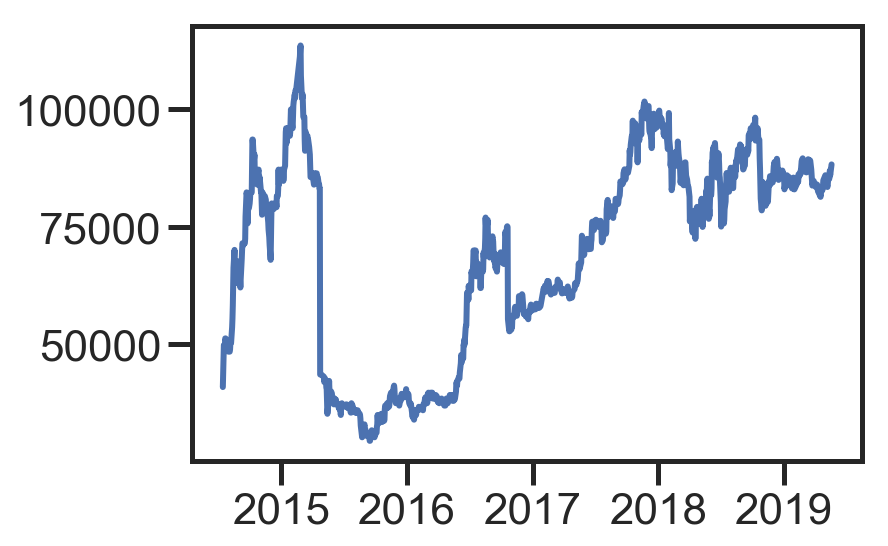

In [7]:
start = datetime(2010,1,1)
end = datetime(2019,1,1)

print(lst_ticket[:5])

df = query.get_historical_data(lst_ticket, start=start)
closed_price = dict()
for ticket in lst_ticket[3:10]:
    closed_price[ticket] = df[df.name == ticket]['close']

series = df[df.name == 'Mobile World Investment Corp']['close']
plt.plot(series)
plt.show()

## Plot ACF and PACF

In [8]:
from statsmodels.tsa.stattools import pacf, acf

def calculate_acf(time_series, lag=20, alpha=0.01):
    x = time_series.values
    acf_value, confint = acf(x, nlags=lag, alpha=alpha)
    confint_lower = confint[:, 0] - acf_value
    confint_upper = confint[:, 1] - acf_value
    return acf_value, confint_upper, confint_lower


def calculate_pacf(time_series, lag=20, alpha=0.01):
    x = time_series.values
    pacf_value, confint = pacf(x, nlags=lag, alpha=alpha)
    confint_lower = confint[:, 0] - pacf_value
    confint_upper = confint[:, 1] - pacf_value
    return pacf_value, confint_upper, confint_lower

## Run model

### ARIMA model

Mobile World Investment Corp
Training result: {'mse': 1536211.1835849087, 'rmse': 1239.439866869268, 'mae': 826.5563122394175, 'mape': 0.9621797354348418}
Testing result: {'mse': 791335.9225923888, 'rmse': 889.5706394617512, 'mae': 711.6734312742698, 'mape': 0.8403365469068101}


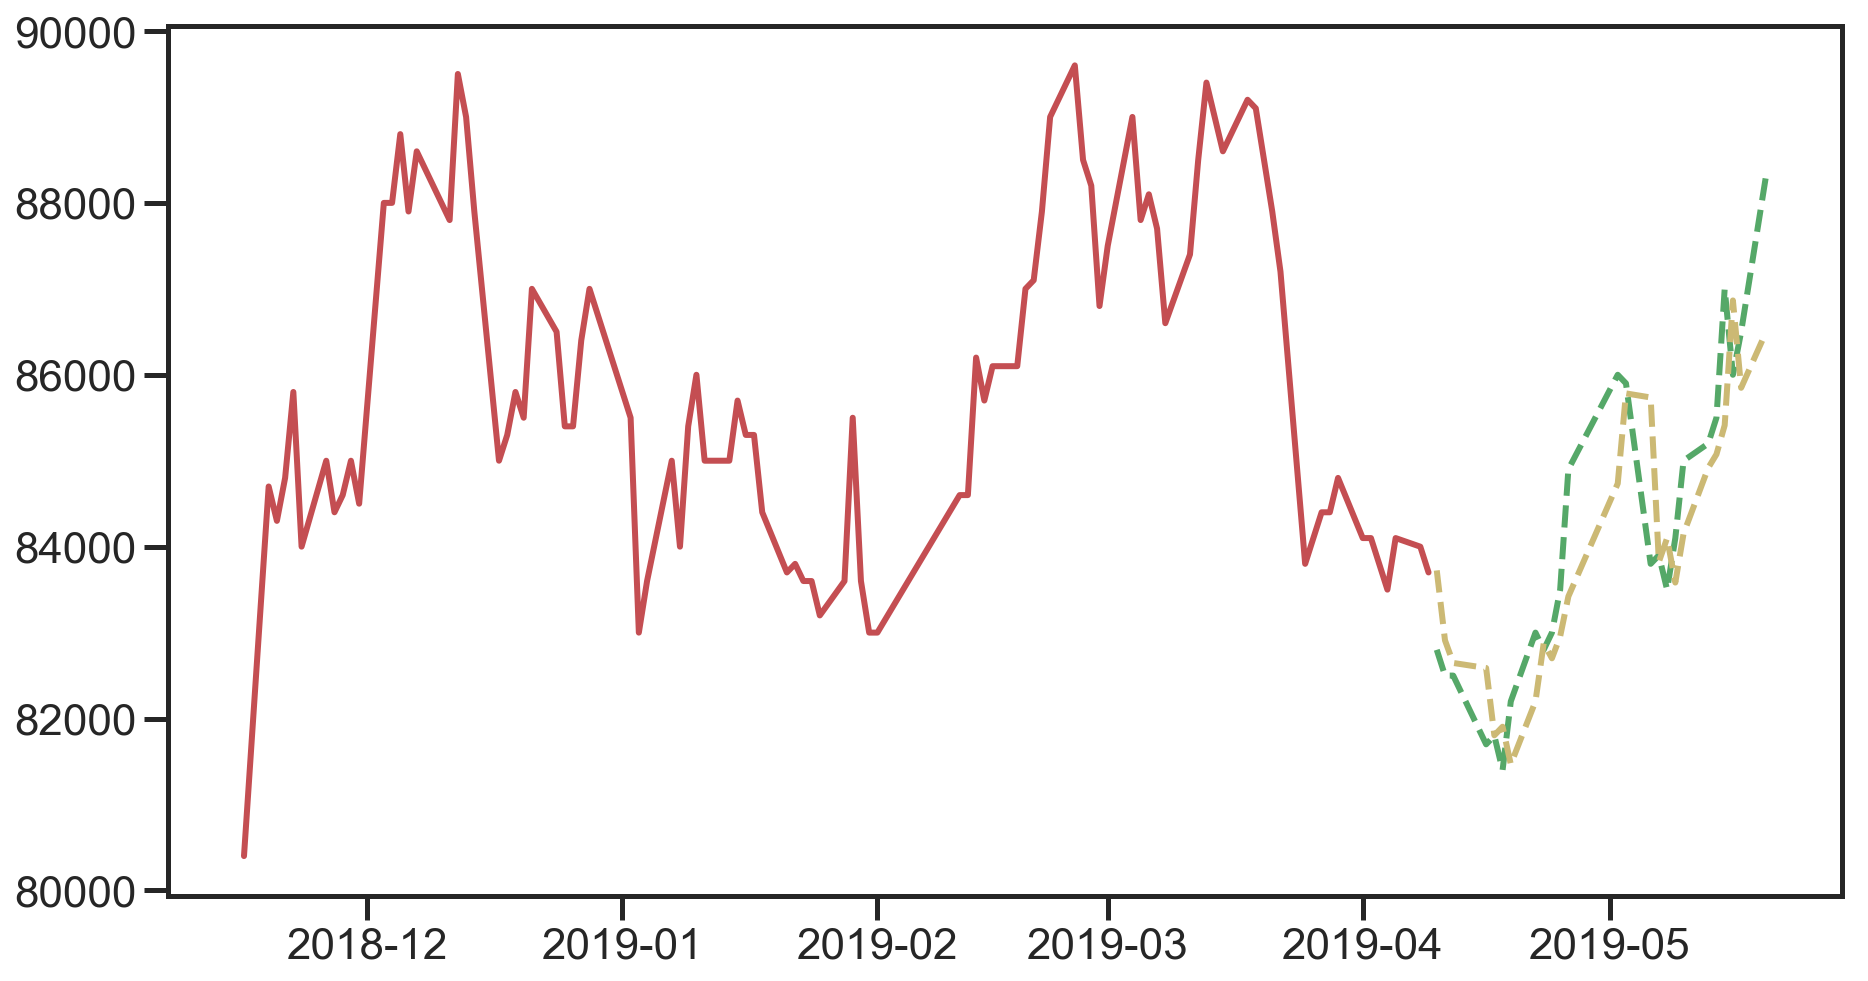

In [9]:
start_train = 0.9
end_train = 0.98
for ticket in lst_ticket[5:6]:
    time_series = df[df.name == ticket]['close']
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result = run_model_with_parameters(train, test, model_selection='ARIMA', order=(1, 1, 2))
    if result['status']:
        validation = result['model'].validate(test)
        time.sleep(1)
        print(ticket)
        print('Training result:', result['train_evaluation'])
        print('Testing result:', result['test_evaluation'])
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
        ax1.plot(train, label='in-sample', color='r', linestyle='-')
        ax1.plot(test, label='held-out', color='g', linestyle='--')
        ax1.plot(validation, label='predicted held-out', color='y', linestyle='--')
    #     ax1.plot(df_ann_validation['yhat'], label='validation held-out', color='purple', linestyle='--')
        plt.show()
    else:
        print('None')

### ANN model

Masan Group Corp
Training result: {'mse': 16694522.843814136, 'rmse': 4085.893151296805, 'mae': 3616.225359516663, 'mape': 4.379598663206747}
Testing result: {'mse': 398137.88801426726, 'rmse': 630.9816859578947, 'mae': 533.6423750652931, 'mape': 0.6106996675160631}


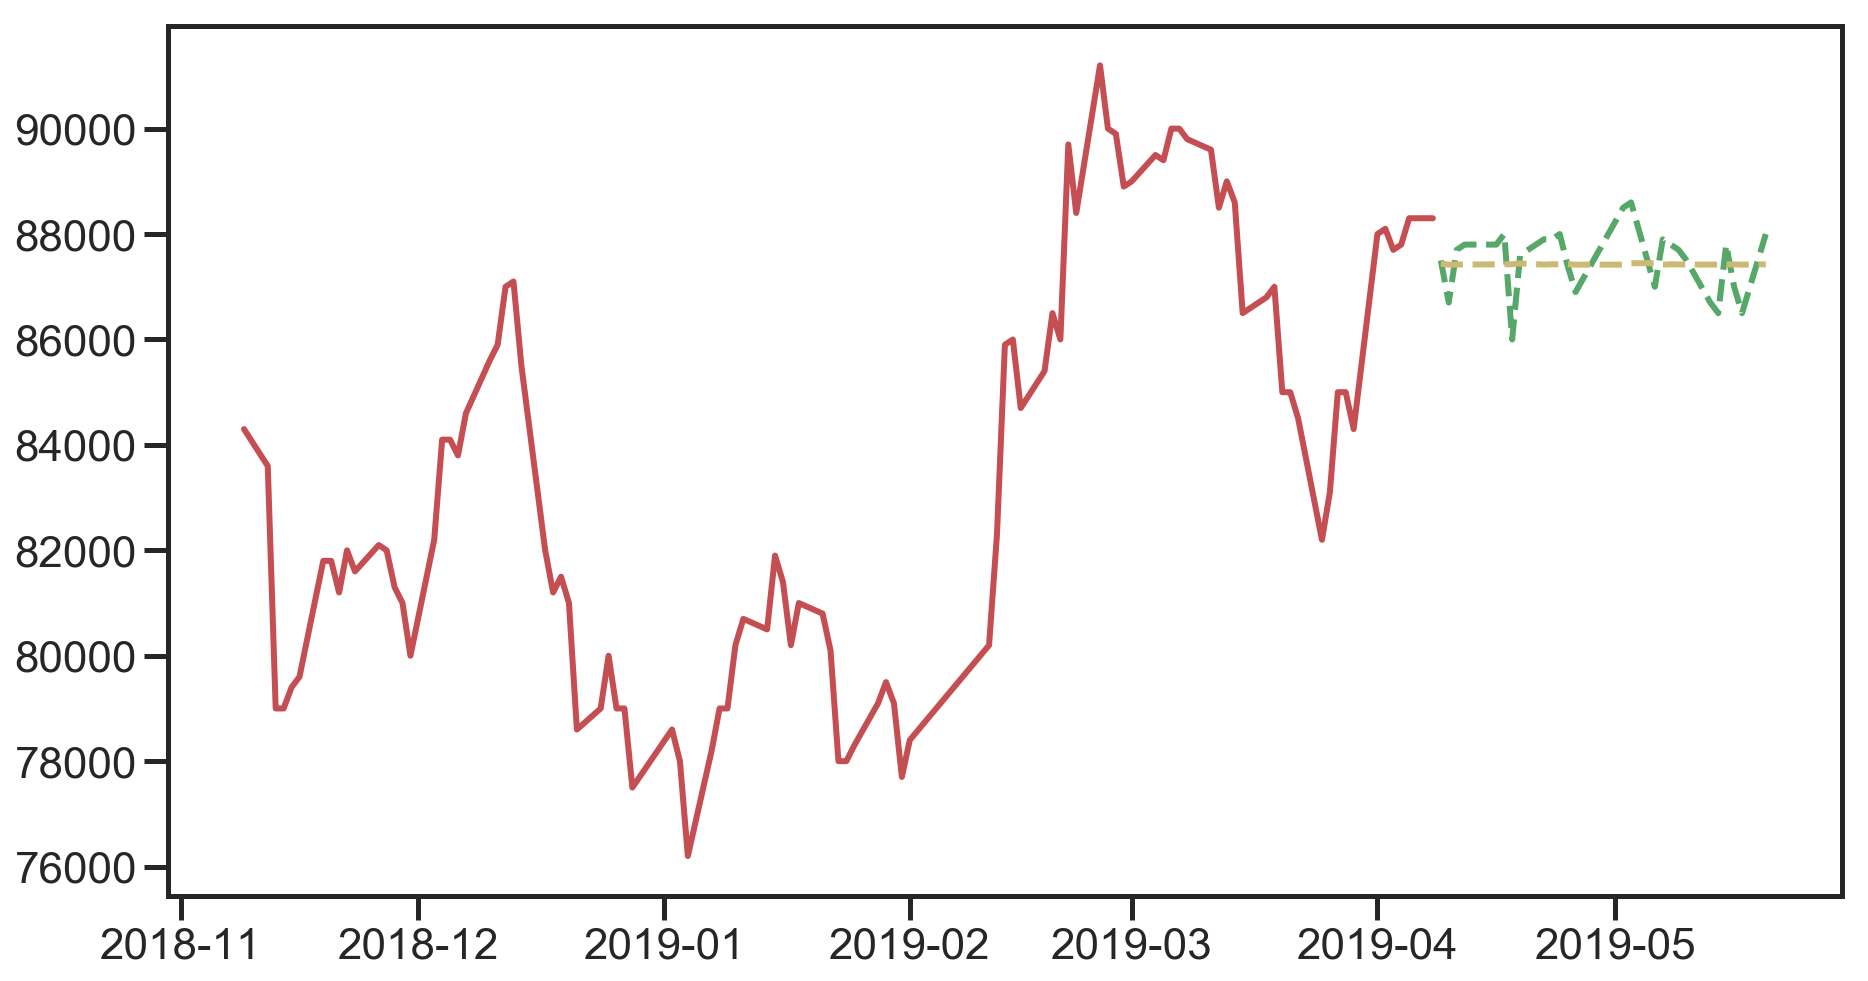

In [10]:
for ticket in lst_ticket[3:4]:
    time_series = df[df.name == ticket]['close']
    
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result = run_model_with_parameters(train, test, model_selection='ANN', lag=1, hidden_layers=(3,1))
    if result['status']:
        validation = result['model'].validate(test)
        time.sleep(1)
        print(ticket)
        print('Training result:', result['train_evaluation'])
        print('Testing result:', result['test_evaluation'])
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
        ax1.plot(train, label='in-sample', color='r', linestyle='-')
        ax1.plot(test, label='held-out', color='g', linestyle='--')
        ax1.plot(validation, label='predicted held-out', color='y', linestyle='--')
    #     ax1.plot(df_ann_validation['yhat'], label='validation held-out', color='purple', linestyle='--')
        plt.show()
    else:
        print('None')

### Hybrid model

Masan Group Corp
Training result: {'mse': 1667404.167611081, 'rmse': 1291.2800500321691, 'mae': 973.1438562527649, 'mape': 1.170684812206426}
Testing result: {'mse': 925357.1013715856, 'rmse': 961.9548333324104, 'mae': 759.9234678503725, 'mape': 0.8699583737037112}


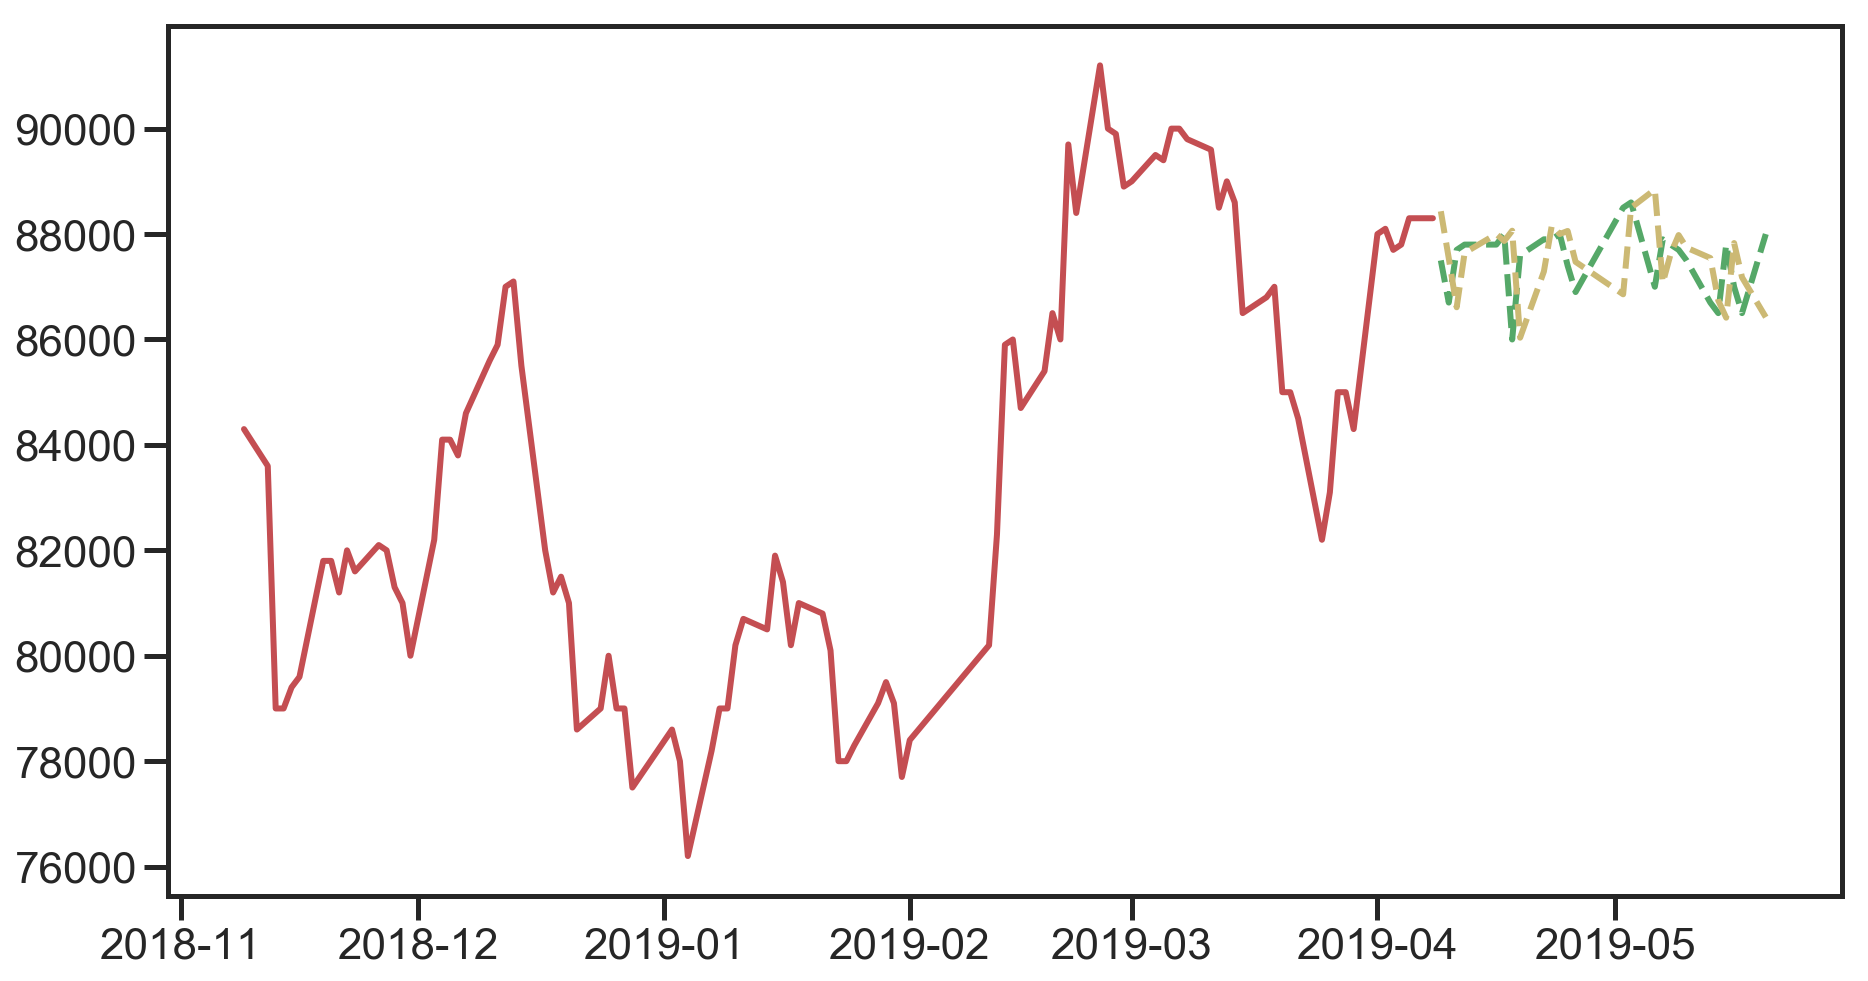

In [11]:
for ticket in lst_ticket[3:4]:
    time_series = df[df.name == ticket]['close']
    
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result = run_model_with_parameters(train, test, model_selection='Hybrid', order=(1, 1, 0), lag=2, hidden_layers=(6, 3))
    if result['status']:
        validation = result['model'].validate(test)
        time.sleep(1)
        print(ticket)
        print('Training result:', result['train_evaluation'])
        print('Testing result:', result['test_evaluation'])
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
        ax1.plot(train, label='in-sample', color='r', linestyle='-')
        ax1.plot(test, label='held-out', color='g', linestyle='--')
        ax1.plot(validation, label='predicted held-out', color='y', linestyle='--')
    #     ax1.plot(df_ann_validation['yhat'], label='validation held-out', color='purple', linestyle='--')
        plt.show()
    else:
        print('None')

### Run model without parameters

In [12]:
lst_hybrid = []
for ticket in lst_ticket:
    time_series = df[df.name == ticket]['close']
    
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result, lst_result = run_model_without_parameters(train, test, model_selection='Hybrid', q=range(0, 4))
    print(ticket, ':', result['lag'], result['hidden_layers'], result['order'])
    print('Training result:', result['train_evaluation'])
    print('Testing result:', result['test_evaluation'])
    lst_hybrid.append({
        'name': ticket,
        'order': result['order'],
        'lags': result['lag'],
        'hidden_layers': result['hidden_layers'],
        'result': result['test_evaluation']
    })


Ho Chi Minh City Infrastructure Investment JSC : 1 (3, 2) (2, 0, 1)
Training result: {'mse': 205927.38225727263, 'rmse': 453.7922236632891, 'mae': 330.41044670632584, 'mape': 1.3454868463490868}
Testing result: {'mse': 61971.64589897382, 'rmse': 248.9410490436919, 'mae': 192.8740802700897, 'mape': 0.8223287677232438}



Ho Chi Minh City Development Joint Stock Commercial Bank : 2 (3, 2) (1, 0, 2)
Training result: {'mse': 533347.6112077461, 'rmse': 730.3065186671595, 'mae': 621.3423823220804, 'mape': 2.2019824014779994}
Testing result: {'mse': 77311.45100712008, 'rmse': 278.0493679315241, 'mae': 203.43697506140597, 'mape': 0.7427951805441918}



Hoa Phat Group JSC : 2 (6, 1) (1, 0, 0)
Training result: {'mse': 531144.3589732648, 'rmse': 728.7965141061426, 'mae': 569.3818945983126, 'mape': 1.7747958712900476}
Testing result: {'mse': 263073.9435414597, 'rmse': 512.9073440120152, 'mae': 410.3302816142662, 'mape': 1.2603479065811667}



Masan Group Corp : 2 (6, 1) (1, 1, 2)
Training result: {'mse': 8983572.7536745, 'rmse': 2997.2608751449216, 'mae': 2670.126095283409, 'mape': 3.1991173896623546}
Testing result: {'mse': 1064507.5679899533, 'rmse': 1031.7497603537174, 'mae': 828.2207163016411, 'mape': 0.9469914576317415}



Military Commercial Joint Stock Bank : 1 (6, 3) (2, 1, 2)
Training result: {'mse': 386907.2323551999, 'rmse': 622.0186752463304, 'mae': 366.9145223253086, 'mape': 1.7428427748401791}
Testing result: {'mse': 57129.25108012178, 'rmse': 239.0172610505814, 'mae': 184.00765099276185, 'mape': 0.8552298466137802}



Mobile World Investment Corp : 3 (7, 1) (1, 0, 0)
Training result: {'mse': 1798948.0797451078, 'rmse': 1341.2487016750874, 'mae': 1059.2368045330854, 'mape': 1.2365289879447638}
Testing result: {'mse': 747703.2293703464, 'rmse': 864.6983458815834, 'mae': 666.7701325501845, 'mape': 0.7902119132152292}



No Va Land Investment Group Corp : 1 (6, 3) (2, 0, 3)
Training result: {'mse': 1709004.5887352573, 'rmse': 1307.28902264773, 'mae': 959.5123310911773, 'mape': 1.644494257083}
Testing result: {'mse': 492772.41464370285, 'rmse': 701.9775029469982, 'mae': 486.7598432651078, 'mape': 0.8382403552984194}



PetroVietnam Fertilizer and Chemicals Corp : 2 (6, 1) (3, 1, 3)
Training result: {'mse': 1377274.5353203577, 'rmse': 1173.5734043170703, 'mae': 953.7218787430262, 'mape': 4.570070716390513}
Testing result: {'mse': 100874.95954275847, 'rmse': 317.60818557266197, 'mae': 240.301074237501, 'mape': 1.3447598902251203}



Phu Nhuan Jewelry JSC : 3 (3, 3) (2, 0, 2)
Training result: {'mse': 4082466.650360094, 'rmse': 2020.5114823628433, 'mae': 1571.2088543759116, 'mape': 1.636980132237399}
Testing result: {'mse': 3831208.2345084785, 'rmse': 1957.3472442335005, 'mae': 1406.6237560740876, 'mape': 1.378955492383061}



Refrigeration Electrical Engineering Corp : 3 (7, 2) (1, 0, 0)
Training result: {'mse': 296348.9415497034, 'rmse': 544.3794095570694, 'mae': 403.2470528019159, 'mape': 1.2352628139573565}
Testing result: {'mse': 108198.78367932177, 'rmse': 328.9358352009124, 'mae': 248.888342416135, 'mape': 0.779995366973403}



Sai Gon Thuong Tin Commercial Joint Stock Bank : 2 (6, 1) (1, 0, 1)
Training result: {'mse': 36930.284895732344, 'rmse': 192.17253939034148, 'mae': 143.74121387903767, 'mape': 1.1688832885901714}
Testing result: {'mse': 31607.020112508853, 'rmse': 177.783632858902, 'mae': 133.22229691382927, 'mape': 1.1111607583119105}



Saigon Beer Alcohol Beverage Corp : 2 (3, 2) (1, 0, 0)
Training result: {'mse': 139227209.96198365, 'rmse': 11799.458036790658, 'mae': 11248.00059446546, 'mape': 4.556394637905327}
Testing result: {'mse': 19897646.53043033, 'rmse': 4460.677810650566, 'mae': 3553.952424585065, 'mape': 1.4149902341547875}



Saigon Securities Incorporation : 2 (6, 1) (3, 0, 3)
Training result: {'mse': 629778.3413011334, 'rmse': 793.5857491797175, 'mae': 706.9798361705325, 'mape': 2.561579925883605}
Testing result: {'mse': 169068.2290312637, 'rmse': 411.17907173306344, 'mae': 317.156409877032, 'mape': 1.228558687518517}



Vietnam Technological And Commercial Joint Stock Bank : 2 (3, 2) (3, 1, 1)
Training result: {'mse': 1567291.0573935204, 'rmse': 1251.9149561346092, 'mae': 1134.969667720485, 'mape': 4.753088243616787}
Testing result: {'mse': 142220.83438921737, 'rmse': 377.12177660434486, 'mae': 341.4095113703712, 'mape': 1.4469039713163703}



Thanh Thanh Cong Tay Ninh JSC : 1 (4, 3) (2, 0, 2)
Training result: {'mse': 124296.22339321277, 'rmse': 352.5566952891588, 'mae': 229.04549523832318, 'mape': 1.1732062122976727}
Testing result: {'mse': 36910.11465323852, 'rmse': 192.12005270985773, 'mae': 151.16149028547008, 'mape': 0.8321773819931082}



Joint Stock Commercial Bank for Foreign Trade of Vietnam : 2 (6, 3) (2, 1, 2)
Training result: {'mse': 715127.9861560205, 'rmse': 845.6524026785595, 'mae': 656.7080907791758, 'mape': 1.1125194248677412}
Testing result: {'mse': 283209.17511174805, 'rmse': 532.1740083015593, 'mae': 405.5908461163151, 'mape': 0.602663903503064}



Vietjet Aviation JSC : 1 (4, 3) (1, 1, 0)
Training result: {'mse': 1596487.3562134665, 'rmse': 1263.5218067819276, 'mae': 927.1736632808492, 'mape': 0.7961415845372891}
Testing result: {'mse': 889491.3736161334, 'rmse': 943.1285032359765, 'mae': 696.7965953111974, 'mape': 0.5954081965536961}



Vietnam Export Import Commercial Joint Stock Bank : 2 (3, 2) (2, 1, 0)
Training result: {'mse': 140452.1108819052, 'rmse': 374.76941028038186, 'mae': 269.3818344866851, 'mape': 1.6663164136599824}
Testing result: {'mse': 121529.21069671494, 'rmse': 348.6103995819903, 'mae': 228.50902597362912, 'mape': 1.2843149947302528}



Vietnam JSCmmercial Bank for Industry and Trade : 2 (7, 2) (1, 1, 1)
Training result: {'mse': 197588.14848723452, 'rmse': 444.50888459876086, 'mae': 335.62167843078265, 'mape': 1.5874606407774445}
Testing result: {'mse': 73328.66822943163, 'rmse': 270.7926664986178, 'mae': 214.96398511031026, 'mape': 1.0232761186304404}



Vietnam Prosperity Joint Stock Commercial Bank : 1 (4, 3) (1, 1, 0)
Training result: {'mse': 97257.39542456866, 'rmse': 311.8611797331766, 'mae': 228.7487060149757, 'mape': 1.127038015528544}
Testing result: {'mse': 16956.50585514565, 'rmse': 130.21714885200663, 'mae': 87.29977059092279, 'mape': 0.46524499705646055}



Vietnam Dairy Products JSC : 1 (6, 3) (3, 0, 0)
Training result: {'mse': 4897813.958009792, 'rmse': 2213.100530479759, 'mae': 1619.6013195980663, 'mape': 1.230809533729127}
Testing result: {'mse': 2562031.128269896, 'rmse': 1600.634601734542, 'mae': 1180.165726386806, 'mape': 0.8956118897626428}



Vincom Retail JSC : 2 (7, 2) (2, 0, 0)
Training result: {'mse': 525677.8575879498, 'rmse': 725.036452592523, 'mae': 523.3140756226044, 'mape': 1.5008817006272257}
Testing result: {'mse': 62953.79797107221, 'rmse': 250.90595443526686, 'mae': 211.19371630241585, 'mape': 0.6005399153125006}



Vingroup JSC : 1 (4, 3) (1, 0, 0)
Training result: {'mse': 4633338.681464128, 'rmse': 2152.519147757838, 'mae': 1247.4284891496857, 'mape': 1.1712331086683163}
Testing result: {'mse': 1994691.9221337363, 'rmse': 1412.3356265894224, 'mae': 916.1662113533004, 'mape': 0.8110761642648033}



Vinhomes JSC : 2 (3, 2) (2, 0, 2)
Training result: {'mse': 889391.1543647541, 'rmse': 943.075370458138, 'mae': 715.906833622103, 'mape': 0.807403988744997}
Testing result: {'mse': 434772.61532876175, 'rmse': 659.3728955066031, 'mae': 461.9090616795118, 'mape': 0.5348700917417076}



Petrovietnam Gas JSC : 1 (6, 1) (1, 0, 0)
Training result: {'mse': 13064139.336187234, 'rmse': 3614.4348570955367, 'mae': 3169.31898354908, 'mape': 3.397981988417673}
Testing result: {'mse': 3360044.1171057993, 'rmse': 1833.0423118700232, 'mae': 1354.3963528598022, 'mape': 1.2471555120201288}


In [14]:
lst_arima = []
for ticket in lst_ticket:
    time_series = df[df.name == ticket]['close']
    
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result, lst_result = run_model_without_parameters(train, test, model_selection='ARIMA', q=range(0, 4))
    print(ticket, ':', result['order'])
    print('Training result:', result['train_evaluation'])
    print('Testing result:', result['test_evaluation'])
    lst_arima.append({
        'name': ticket,
        'order': result['order'],
#         'lags': result['lag'],
#         'hidden_layers': result['hidden_layers'],
        'result': result['test_evaluation']
    })


Ho Chi Minh City Infrastructure Investment JSC : (2, 0, 1)
Training result: {'mse': 198782.47301065567, 'rmse': 445.85028093593894, 'mae': 321.5014746067505, 'mape': 1.309721118644413}
Testing result: {'mse': 87500.46761494968, 'rmse': 295.80477956745335, 'mae': 225.24103151753857, 'mape': 0.9597025095989529}



Ho Chi Minh City Development Joint Stock Commercial Bank : (1, 0, 2)
Training result: {'mse': 164268.81290066868, 'rmse': 405.30089180838064, 'mae': 327.89832524462327, 'mape': 1.1692294063066901}
Testing result: {'mse': 146284.52129028057, 'rmse': 382.47159540321496, 'mae': 308.26902529816704, 'mape': 1.1251111626812564}



Hoa Phat Group JSC : (1, 0, 0)
Training result: {'mse': 417125.2095414333, 'rmse': 645.8523124843894, 'mae': 470.6770457395265, 'mape': 1.4642236325165137}
Testing result: {'mse': 192058.4456465541, 'rmse': 438.24473259419113, 'mae': 304.795764230329, 'mape': 0.9297061255483845}



Masan Group Corp : (1, 1, 2)
Training result: {'mse': 6121304.646137163, 'rmse': 2474.127047291057, 'mae': 1187.4063608881838, 'mape': 1.4323825695651395}
Testing result: {'mse': 785454.8352061186, 'rmse': 886.2588985201326, 'mae': 666.2935383197954, 'mape': 0.7628445364123899}



Military Commercial Joint Stock Bank : (2, 1, 2)
Training result: {'mse': 437696.97536038136, 'rmse': 661.586710386765, 'mae': 310.7576560054654, 'mape': 1.4805634263033716}
Testing result: {'mse': 40798.941686043916, 'rmse': 201.9874790328448, 'mae': 159.2300154372298, 'mape': 0.7408511448652894}



Mobile World Investment Corp : (1, 0, 0)
Training result: {'mse': 1240274.5663660197, 'rmse': 1113.6761496799775, 'mae': 804.1835020294309, 'mape': 0.9355057782602892}
Testing result: {'mse': 757814.8404905475, 'rmse': 870.5256116223965, 'mae': 675.7756298287143, 'mape': 0.7981353864024755}



No Va Land Investment Group Corp : (2, 0, 3)
Training result: {'mse': 8832313.188022874, 'rmse': 2971.920791007539, 'mae': 1244.1071190453767, 'mape': 2.1334719380206155}
Testing result: {'mse': 520447.034769927, 'rmse': 721.4201513472763, 'mae': 523.3741534058954, 'mape': 0.8999690273714359}



PetroVietnam Fertilizer and Chemicals Corp : (3, 1, 3)
Training result: {'mse': 877114.7077886519, 'rmse': 936.5440234119546, 'mae': 432.84085703687697, 'mape': 2.1348438238102356}
Testing result: {'mse': 81774.04021029416, 'rmse': 285.9616061821834, 'mae': 219.74979432094005, 'mape': 1.2359208033549232}



Phu Nhuan Jewelry JSC : (2, 0, 2)
Training result: {'mse': 8711399.441871695, 'rmse': 2951.507994546465, 'mae': 1244.3051395315745, 'mape': 1.3051137873661398}
Testing result: {'mse': 2156309.3198103756, 'rmse': 1468.4377139703188, 'mae': 942.4345795272488, 'mape': 0.9232226917393137}



Refrigeration Electrical Engineering Corp : (1, 0, 0)
Training result: {'mse': 228842.83944306418, 'rmse': 478.3752078056138, 'mae': 348.7215659683923, 'mape': 1.0727846856234977}
Testing result: {'mse': 126036.52492857267, 'rmse': 355.0162319226723, 'mae': 258.85908293539785, 'mape': 0.8107861216098751}



Sai Gon Thuong Tin Commercial Joint Stock Bank : (1, 0, 1)
Training result: {'mse': 33919.79407780276, 'rmse': 184.1732718876514, 'mae': 135.85334608369885, 'mape': 1.1063810984397209}
Testing result: {'mse': 31648.94736420605, 'rmse': 177.90151029208843, 'mae': 123.49891023369302, 'mape': 1.028619912615538}



Saigon Beer Alcohol Beverage Corp : (1, 0, 0)
Training result: {'mse': 14756320.425929636, 'rmse': 3841.3956351734505, 'mae': 2491.9737204456715, 'mape': 1.022669316431676}
Testing result: {'mse': 24490971.923188485, 'rmse': 4948.8354108000485, 'mae': 3569.5689627350503, 'mape': 1.4241532830430228}



Saigon Securities Incorporation : (3, 0, 3)
Training result: {'mse': 274332.8447519479, 'rmse': 523.7679302438704, 'mae': 322.26625558025256, 'mape': 1.1646738048769445}
Testing result: {'mse': 141521.01901684832, 'rmse': 376.1927950092191, 'mae': 293.7973381782358, 'mape': 1.1381574567578152}



Vietnam Technological And Commercial Joint Stock Bank : (3, 1, 1)
Training result: {'mse': 1650559.014891263, 'rmse': 1284.7408356907097, 'mae': 660.9235152528781, 'mape': 2.7074918794557252}
Testing result: {'mse': 198008.27344987862, 'rmse': 444.9812057265774, 'mae': 302.3539324712459, 'mape': 1.2745086513127442}



Thanh Thanh Cong Tay Ninh JSC : (2, 0, 2)
Training result: {'mse': 940239.2130859377, 'rmse': 969.659328365348, 'mae': 293.1224004332228, 'mape': 1.4724280978040742}
Testing result: {'mse': 29922.769271883877, 'rmse': 172.981991177937, 'mae': 116.35446226381562, 'mape': 0.6404498581430076}



Joint Stock Commercial Bank for Foreign Trade of Vietnam : (2, 1, 2)
Training result: {'mse': 2111354.700296085, 'rmse': 1453.0501368831308, 'mae': 772.1191046299102, 'mape': 1.324920806831662}
Testing result: {'mse': 289668.2956770879, 'rmse': 538.2084128635374, 'mae': 412.18481833638947, 'mape': 0.6124035066293845}



Vietjet Aviation JSC : (1, 1, 0)
Training result: {'mse': 1318318.7904693794, 'rmse': 1148.1806436573381, 'mae': 830.7386585017413, 'mape': 0.7140108532486449}
Testing result: {'mse': 534507.268518198, 'rmse': 731.1000400206514, 'mae': 524.2541149999015, 'mape': 0.44867180941596363}



Vietnam Export Import Commercial Joint Stock Bank : (2, 1, 0)
Training result: {'mse': 112476.18366858314, 'rmse': 335.3746914550696, 'mae': 233.84851302863794, 'mape': 1.4699412389083721}
Testing result: {'mse': 109103.87532579906, 'rmse': 330.30875756752056, 'mae': 235.29863184753484, 'mape': 1.324691029285206}



Vietnam JSCmmercial Bank for Industry and Trade : (1, 1, 1)
Training result: {'mse': 543768.412345028, 'rmse': 737.4065448211238, 'mae': 394.9705310238047, 'mape': 1.8464530027627768}
Testing result: {'mse': 76610.2614537667, 'rmse': 276.78558751092277, 'mae': 227.2410099083231, 'mape': 1.0819095273066561}



Vietnam Prosperity Joint Stock Commercial Bank : (1, 1, 0)
Training result: {'mse': 127366.89107263113, 'rmse': 356.8849829743907, 'mae': 256.90028096151264, 'mape': 1.2619802173932935}
Testing result: {'mse': 21892.60053372172, 'rmse': 147.96148327764803, 'mae': 90.83507588448184, 'mape': 0.4852222169681561}



Vietnam Dairy Products JSC : (3, 0, 0)
Training result: {'mse': 4800441.078508215, 'rmse': 2190.9908896451884, 'mae': 1604.5875214846915, 'mape': 1.220930647639142}
Testing result: {'mse': 2611374.843164292, 'rmse': 1615.9748893978187, 'mae': 1173.2788925119698, 'mape': 0.8899825501798911}



Vincom Retail JSC : (2, 0, 0)
Training result: {'mse': 1596270.308013455, 'rmse': 1263.435913694658, 'mae': 692.127475434502, 'mape': 2.0129734603574336}
Testing result: {'mse': 107587.31380837069, 'rmse': 328.0050514982516, 'mae': 254.7563899374336, 'mape': 0.721914917686491}



Vingroup JSC : (1, 0, 0)
Training result: {'mse': 3240717.604609699, 'rmse': 1800.1993235777252, 'mae': 1039.8620702159901, 'mape': 0.9794694877213137}
Testing result: {'mse': 1793769.8566797834, 'rmse': 1339.3169366060386, 'mae': 953.9885407601821, 'mape': 0.845631769154814}



Vinhomes JSC : (2, 0, 2)
Training result: {'mse': 1673192.880379431, 'rmse': 1293.5195709301931, 'mae': 940.1173060598429, 'mape': 1.0426271375468932}
Testing result: {'mse': 478374.9095484464, 'rmse': 691.6465206653226, 'mae': 560.1657114467147, 'mape': 0.6490656747910261}



Petrovietnam Gas JSC : (1, 0, 0)
Training result: {'mse': 2861899.3027501437, 'rmse': 1691.7148999610258, 'mae': 1292.0466945413589, 'mape': 1.3718736397452125}
Testing result: {'mse': 3086724.5385030922, 'rmse': 1756.9076636246687, 'mae': 1339.4778413058555, 'mape': 1.2317165939549215}


In [15]:
lst_ann = []
for ticket in lst_ticket:
    time_series = df[df.name == ticket]['close']
    
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result, lst_result = run_model_without_parameters(train, test, model_selection='ANN', q=range(0, 4))
    print(ticket, ':', result['lag'], result['hidden_layers'])
    print('Training result:', result['train_evaluation'])
    print('Testing result:', result['test_evaluation'])
    lst_ann.append({
        'name': ticket,
#         'order': result['order'],
        'lags': result['lag'],
        'hidden_layers': result['hidden_layers'],
        'result': result['test_evaluation']
    })


Ho Chi Minh City Infrastructure Investment JSC : 1 (6, 3)
Training result: {'mse': 212337.7418001407, 'rmse': 460.80119552811567, 'mae': 346.9509171805308, 'mape': 1.4210115994721966}
Testing result: {'mse': 73454.64852962017, 'rmse': 271.0251806191081, 'mae': 197.42125873695673, 'mape': 0.8432942211947224}



Ho Chi Minh City Development Joint Stock Commercial Bank : 1 (4, 2)
Training result: {'mse': 580860.2960428558, 'rmse': 762.1419133224834, 'mae': 539.1910081576214, 'mape': 1.9501373576331087}
Testing result: {'mse': 52177.949433127935, 'rmse': 228.42493172403036, 'mae': 164.01252581931735, 'mape': 0.5977464256624632}



Hoa Phat Group JSC : 1 (7, 3)
Training result: {'mse': 475640.22898765595, 'rmse': 689.666752125732, 'mae': 510.86532446833826, 'mape': 1.5963244156242635}
Testing result: {'mse': 178327.72290315054, 'rmse': 422.2886724779041, 'mae': 300.2565997950384, 'mape': 0.9180310804318202}



Masan Group Corp : 1 (3, 1)
Training result: {'mse': 16694522.843814136, 'rmse': 4085.893151296805, 'mae': 3616.225359516663, 'mape': 4.379598663206747}
Testing result: {'mse': 398137.88801426726, 'rmse': 630.9816859578947, 'mae': 533.6423750652931, 'mape': 0.6106996675160631}



Military Commercial Joint Stock Bank : 1 (6, 3)
Training result: {'mse': 162821.60078006948, 'rmse': 403.511586921701, 'mae': 293.6299328779729, 'mape': 1.4191320201334712}
Testing result: {'mse': 48564.805750908956, 'rmse': 220.37424021629423, 'mae': 166.42741976128295, 'mape': 0.77678466099825}



Mobile World Investment Corp : 2 (6, 3)
Training result: {'mse': 1276905.270467535, 'rmse': 1130.0023320628745, 'mae': 889.9444256328923, 'mape': 1.0325437554111205}
Testing result: {'mse': 899148.8539715862, 'rmse': 948.2345985944545, 'mae': 734.343094294513, 'mape': 0.8698432472631893}



No Va Land Investment Group Corp : 3 (5, 2)
Training result: {'mse': 1785460.7988064054, 'rmse': 1336.2113600798361, 'mae': 1135.477419190782, 'mape': 1.9715024736066473}
Testing result: {'mse': 389057.6314241351, 'rmse': 623.7448448076626, 'mae': 416.7106917310575, 'mape': 0.7158454207415567}



PetroVietnam Fertilizer and Chemicals Corp : 1 (6, 3)
Training result: {'mse': 195840.860876744, 'rmse': 442.53910660725114, 'mae': 340.90035712764586, 'mape': 1.6379507268221234}
Testing result: {'mse': 62787.878617677095, 'rmse': 250.57509576507618, 'mae': 194.70129836908143, 'mape': 1.0963223499756884}



Phu Nhuan Jewelry JSC : 1 (7, 3)
Training result: {'mse': 1800709.9600295871, 'rmse': 1341.9053468965637, 'mae': 1030.525836877144, 'mape': 1.0756183285344423}
Testing result: {'mse': 2254852.108360129, 'rmse': 1501.616498430984, 'mae': 971.2001793348812, 'mape': 0.9528075794301937}



Refrigeration Electrical Engineering Corp : 1 (7, 3)
Training result: {'mse': 238219.3634662272, 'rmse': 488.07721055815256, 'mae': 358.93119345142287, 'mape': 1.110622134614186}
Testing result: {'mse': 129896.29587749847, 'rmse': 360.4112871116809, 'mae': 274.6279286195941, 'mape': 0.8637020222424266}



Sai Gon Thuong Tin Commercial Joint Stock Bank : 3 (6, 3)
Training result: {'mse': 148248.5356030204, 'rmse': 385.03056450497587, 'mae': 285.6585145131425, 'mape': 2.3609220663603065}
Testing result: {'mse': 22874.5252652827, 'rmse': 151.24326518983483, 'mae': 105.64931041054871, 'mape': 0.8844580123048144}



Saigon Beer Alcohol Beverage Corp : 1 (4, 3)
Training result: {'mse': 12873899.76764742, 'rmse': 3588.021706685652, 'mae': 2509.124989498953, 'mape': 1.0268296553017258}
Testing result: {'mse': 22535782.38412122, 'rmse': 4747.186786310522, 'mae': 3648.6033139778165, 'mape': 1.4632083508399825}



Saigon Securities Incorporation : 1 (4, 3)
Training result: {'mse': 166411.4569131677, 'rmse': 407.93560388027873, 'mae': 316.82887743206464, 'mape': 1.1445560313229548}
Testing result: {'mse': 154671.43890535375, 'rmse': 393.2828993299273, 'mae': 313.9373082698817, 'mape': 1.2229545800950037}



Vietnam Technological And Commercial Joint Stock Bank : 1 (6, 1)
Training result: {'mse': 826853.4613170688, 'rmse': 909.3148306923564, 'mae': 706.7234546917331, 'mape': 3.0292230227318195}
Testing result: {'mse': 113356.8592674608, 'rmse': 336.6851040177762, 'mae': 241.20525224435406, 'mape': 1.0329331383987048}



Thanh Thanh Cong Tay Ninh JSC : 1 (4, 3)
Training result: {'mse': 86668.8110394494, 'rmse': 294.3956708911485, 'mae': 212.2970354306442, 'mape': 1.090527003888576}
Testing result: {'mse': 25209.03992016783, 'rmse': 158.77354918300412, 'mae': 116.91921431705417, 'mape': 0.6466815762979821}



Joint Stock Commercial Bank for Foreign Trade of Vietnam : 1 (4, 3)
Training result: {'mse': 972150.3888973496, 'rmse': 985.9768703663132, 'mae': 763.8078256371917, 'mape': 1.2744876563302003}
Testing result: {'mse': 260372.28988068577, 'rmse': 510.266881034509, 'mae': 420.28706227454006, 'mape': 0.6249097423707441}



Vietjet Aviation JSC : 2 (6, 2)
Training result: {'mse': 1246340.7866162574, 'rmse': 1116.396339395762, 'mae': 827.4791432478343, 'mape': 0.7147924173015766}
Testing result: {'mse': 465704.01239188487, 'rmse': 682.4250965431187, 'mae': 502.8672753935122, 'mape': 0.43107084807300555}



Vietnam Export Import Commercial Joint Stock Bank : 3 (7, 3)
Training result: {'mse': 126141.74554815341, 'rmse': 355.1643922863797, 'mae': 275.40019293072237, 'mape': 1.7326120075528255}
Testing result: {'mse': 108388.6758795677, 'rmse': 329.22435493074886, 'mae': 213.93698881758667, 'mape': 1.2027127148949608}



Vietnam JSCmmercial Bank for Industry and Trade : 1 (4, 3)
Training result: {'mse': 260660.53088233186, 'rmse': 510.54924432647226, 'mae': 407.3589438721839, 'mape': 1.9177019401869277}
Testing result: {'mse': 74627.86439953667, 'rmse': 273.1810103201478, 'mae': 215.78527722351072, 'mape': 1.0305885758259474}



Vietnam Prosperity Joint Stock Commercial Bank : 2 (6, 2)
Training result: {'mse': 107769.78553554765, 'rmse': 328.28308749545363, 'mae': 234.74951896002153, 'mape': 1.1805263033051934}
Testing result: {'mse': 22646.479010585575, 'rmse': 150.4874712744738, 'mae': 90.24421519718413, 'mape': 0.48334032272205646}



Vietnam Dairy Products JSC : 1 (6, 3)
Training result: {'mse': 7458221.037611196, 'rmse': 2730.9743751289934, 'mae': 1971.8770947140067, 'mape': 1.5277257171176961}
Testing result: {'mse': 2218554.13363046, 'rmse': 1489.4811625631457, 'mae': 1073.826672122577, 'mape': 0.8146090413243409}



Vincom Retail JSC : 3 (4, 1)
Training result: {'mse': 374830.99255898723, 'rmse': 612.2344261465433, 'mae': 498.56819320363417, 'mape': 1.428806248137393}
Testing result: {'mse': 106151.53337930728, 'rmse': 325.8090443485375, 'mae': 261.1651576616132, 'mape': 0.7371476471371631}



Vingroup JSC : 1 (7, 3)
Training result: {'mse': 3429347.0030381996, 'rmse': 1851.849616744891, 'mae': 1162.0663387974073, 'mape': 1.1068402155716786}
Testing result: {'mse': 1759941.261757088, 'rmse': 1326.6277781492017, 'mae': 924.999781453415, 'mape': 0.8199657019585919}



Vinhomes JSC : 1 (3, 3)
Training result: {'mse': 2680129.4179520695, 'rmse': 1637.1100811955407, 'mae': 1324.992147555933, 'mape': 1.5121203206039304}
Testing result: {'mse': 246754.69893309654, 'rmse': 496.74409803549406, 'mae': 444.2679358429159, 'mape': 0.5151024260764131}



Petrovietnam Gas JSC : 2 (6, 2)
Training result: {'mse': 3320870.3077088436, 'rmse': 1822.3255218837396, 'mae': 1416.4257066251619, 'mape': 1.5195861607637386}
Testing result: {'mse': 2643140.5210224213, 'rmse': 1625.7738222220278, 'mae': 1257.488457747411, 'mape': 1.1568840084474747}


Masan Group Corp
Training result: {'mse': 3422088.9438324617, 'rmse': 1849.8889004025245, 'mae': 1386.1845557687561, 'mape': 1.6482306620797225}
Testing result: {'mse': 1359486.512642771, 'rmse': 1165.9702022962556, 'mae': 1001.4643001554185, 'mape': 1.1454187942424272}


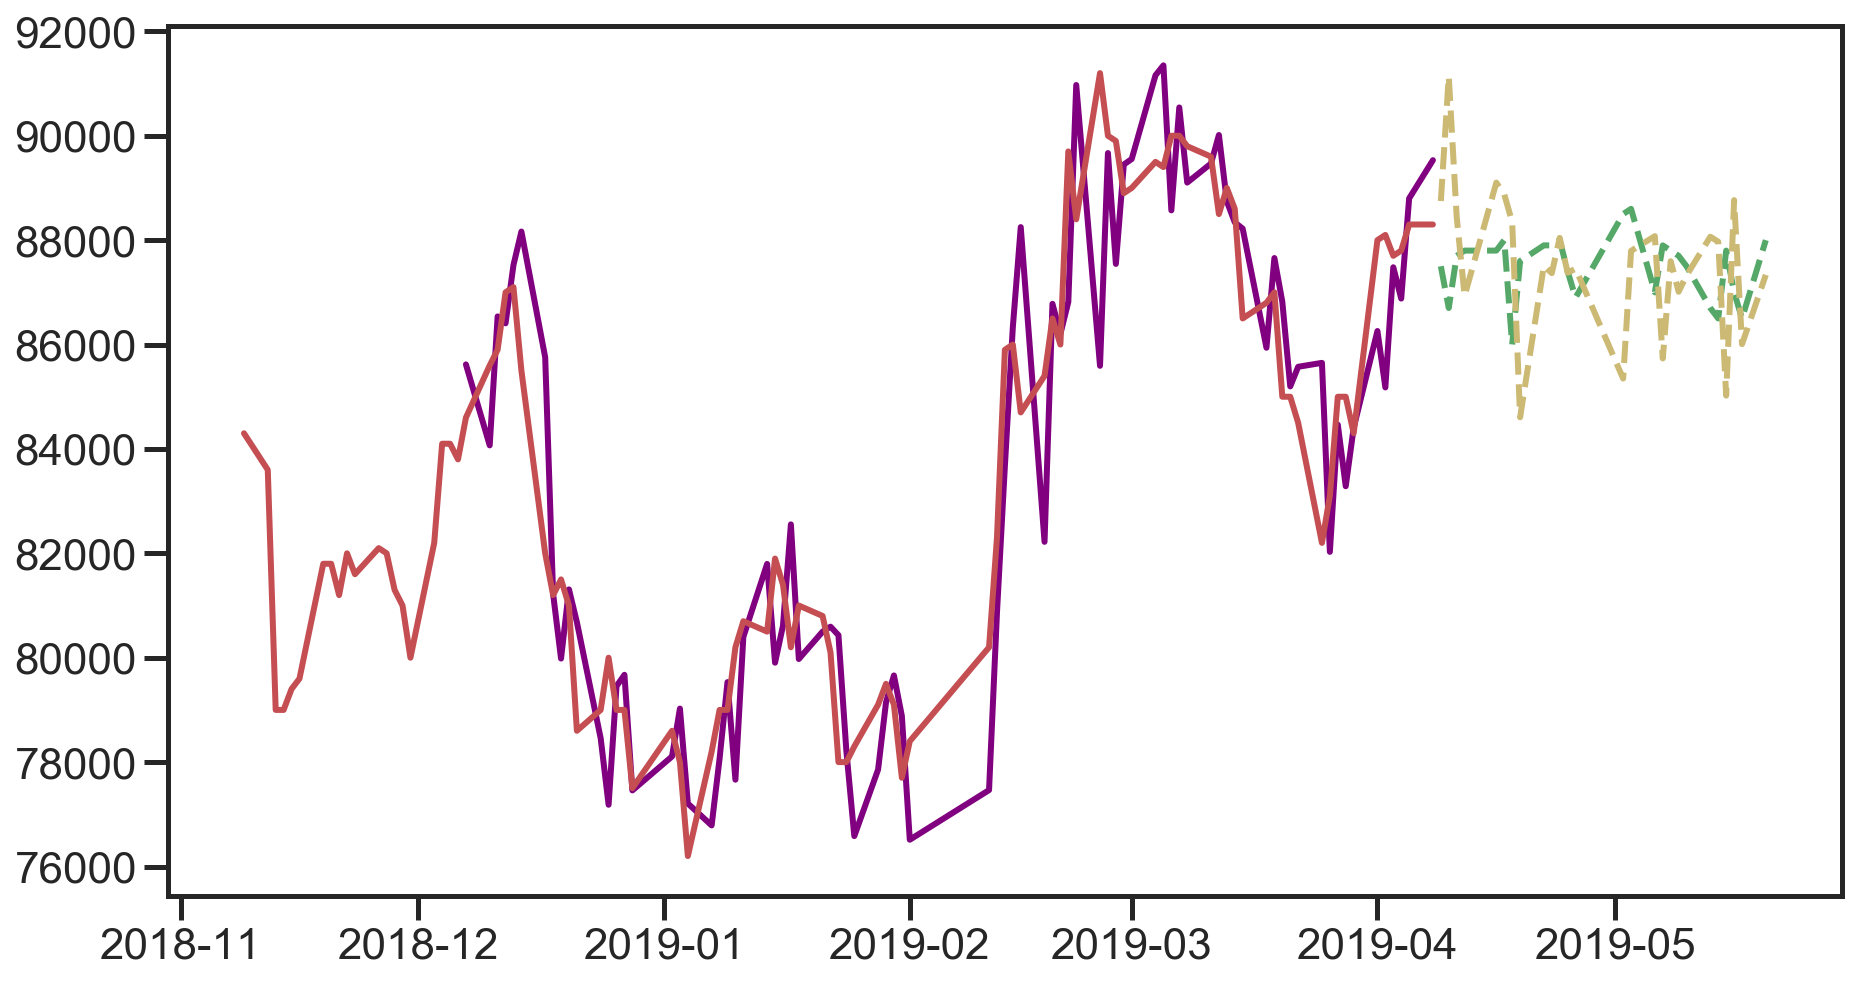

In [19]:
for ticket in lst_ticket[3:4]:
    time_series = df[df.name == ticket]['close']
    # split data
    time_series = time_series.sort_index()
    size = len(time_series)
    train_start = int(start_train * size)
    train_end = int(end_train * size)
    train, test = time_series[train_start:train_end], time_series[train_end:]
    
    result = run_model_with_parameters(train, test, model_selection='LSTM+GBM', window_size=10, lag=10)
    if result['status']:
        validation = result['model'].validate(test)
        insample_prediction = result['model'].get_insample_prediction()
        time.sleep(1)
        print(ticket)
        print('Training result:', result['train_evaluation'])
        print('Testing result:', result['test_evaluation'])
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
        ax1.plot(insample_prediction, label='in-sample', color='purple', linestyle='-')
        ax1.plot(train, label='in-sample', color='r', linestyle='-')
        ax1.plot(test, label='held-out', color='g', linestyle='--')
        ax1.plot(validation, label='predicted held-out', color='y', linestyle='--')
    #     ax1.plot(df_ann_validation['yhat'], label='validation held-out', color='purple', linestyle='--')
        plt.show()
    else:
        print('None')

In [ ]:
# print(result['test_evaluation'])
# lst_dct_result = list()
# for result_ in lst_result:
#     lst_dct_result.append({
#         'order': result_['order'],
#         'mse': result_['test_evaluation']['mse'],
#         'rmse': result_['test_evaluation']['rmse'],
#         'mae': result_['test_evaluation']['mae'],
#         'mape': result_['test_evaluation']['mape'],
#     })
# df_result = pd.DataFrame(data=lst_dct_result)
# df_result.head(20)

In [17]:
df_mae = pd.DataFrame(index=lst_ticket)
df_mae['hybrid'] = [item['result']['mae'] for item in lst_hybrid]
df_mae['arima'] = [item['result']['mae'] for item in lst_arima]
df_mae['ann'] = [item['result']['mae'] for item in lst_ann]
df_mae

,hybrid,arima,ann
Ho Chi Minh City Infrastructure Investment JSC,192.87408,225.24103,197.42126
Ho Chi Minh City Development Joint Stock Commercial Bank,203.43698,308.26903,164.01253
Hoa Phat Group JSC,410.33028,304.79576,300.25660
Masan Group Corp,828.22072,666.29354,533.64238
Military Commercial Joint Stock Bank,184.00765,159.23002,166.42742
Mobile World Investment Corp,666.77013,675.77563,734.34309
No Va Land Investment Group Corp,486.75984,523.37415,416.71069
PetroVietnam Fertilizer and Chemicals Corp,240.30107,219.74979,194.70130
Phu Nhuan Jewelry JSC,1406.62376,942.43458,971.20018
Refrigeration Electrical Engineering Corp,248.88834,258.85908,274.62793
